In [2]:
import kkcalc
from kkcalc import data
from kkcalc import kk
import numpy as np
import matplotlib.pyplot as plt
import pathlib, json
import pandas as pd

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

In [3]:
# I use the timestamps in the various files to interpolate/bin signals onto energy
def read_NEXAFS(scan_num,base,detector='WAXS'):
    mesh = pd.read_csv(list(pathlib.Path(base,scan_num).glob('*Au Mesh*.csv'))[0])
    sample_current = pd.read_csv(list(pathlib.Path(base,scan_num).glob('*Sample Current*.csv'))[0])
    primary = pd.read_csv(list(base.glob(scan_num + '*primary.csv'))[0])
    beamstop = pd.read_csv(list(pathlib.Path(base,scan_num).glob(f'*{detector}*monitor.csv'))[0])
    return primary, mesh, sample_current, beamstop

def interp_NEXAFS(primary, mesh, sample, beamstop,detector='WAXS'):
    mesh_interp = np.interp(primary['time'],mesh['time'],mesh['RSoXS Au Mesh Current'])
    sample_interp = np.interp(primary['time'],sample['time'],sample['RSoXS Sample Current'])
    beamstop_interp = np.interp(primary['time'],beamstop['time'],beamstop[f'{detector} Beamstop'])
    return mesh_interp, sample_interp, beamstop_interp

def read_interp(scan_num, base, detector='WAXS'):
    print(f'{detector} detector selected')
    primary, mesh, sample_current, beamstop = read_NEXAFS(scan_num, base, detector=detector)
    energy = primary['en_monoen_readback']
    mesh_interp, sample_interp, beamstop_interp = interp_NEXAFS(primary, mesh, sample_current, beamstop, detector=detector)
    return energy, mesh_interp, sample_interp, beamstop_interp

def get_pol(scan_num, base):
    abs_pol = round(pd.read_csv(list(base.joinpath(scan_num).glob('*baseline*'))[0])['en_polarization'][0], 0)
    sample_pol = round(pd.read_csv(list(base.joinpath(scan_num).glob('*baseline*'))[0])['en_sample_polarization'][0], 0) 
    return abs_pol, sample_pol

def get_name(scan_num, base):
    loaded_json = json.load(open((list(pathlib.Path(base, scan_num).glob('*json*')))[0], 'r'))
    name = loaded_json[1]['sample_name']
    return name

def calculateMW(formula):
    atomic_weights = {'C': 12.0107, 'H': 1.00784, 'O': 15.999, 'Cl': 35.453, 'S': 32.065, 'F': 18.998, 'N': 14.007}
    result = 0
    for key, value in formula.items():
        result += value * atomic_weights[key]
    return result

def calculateDP(mw_polymer, mw_monomer):
    return round(mw_polymer/mw_monomer)

In [10]:
# Redefine paths as needed
notebookPath = pathlib.Path.cwd()
rootPath = notebookPath.parent.parent.parent
samplePath = rootPath.joinpath('beamline_data', 'BNL-RSoXS-Jul2022', 'rsoxs', 'nexafs_raw')
diodePath = samplePath.parent.joinpath('calibration_2022-08-01')

# Define a path for dielectric function files
difxnPath = samplePath.parent.joinpath('dielectric_fxns')

# Uncomment if there is HOPG data
# hopg_path = pathlib.Path.cwd().joinpath()

In [13]:
sorted(map(lambda x: x.name[:5], diodePath.glob('*iode-primary.csv')))

['43135',
 '43136',
 '43137',
 '43138',
 '43139',
 '43183',
 '43184',
 '43185',
 '43186']

In [19]:
scans_list = [file.name for file in samplePath.glob('*-primary.csv')]
scans_list.sort()
scans_list = pd.Series(scans_list)
display(scans_list)
print()

diode_list = [file.name for file in diodePath.glob('*-primary.csv')]
diode_list.sort()
diode_list = pd.Series(diode_list)
display(diode_list)

0     43095-nexafs2-primary.csv
1     43096-nexafs2-primary.csv
2     43097-nexafs2-primary.csv
3     43098-nexafs2-primary.csv
4     43099-nexafs2-primary.csv
5     43100-nexafs1-primary.csv
6     43101-nexafs1-primary.csv
7     43102-nexafs1-primary.csv
8     43103-nexafs1-primary.csv
9     43104-nexafs1-primary.csv
10    43105-nexafs4-primary.csv
11    43106-nexafs4-primary.csv
12    43107-nexafs4-primary.csv
13    43108-nexafs4-primary.csv
14    43109-nexafs4-primary.csv
15    43110-nexafs3-primary.csv
16    43111-nexafs3-primary.csv
17    43112-nexafs3-primary.csv
18    43113-nexafs3-primary.csv
19    43114-nexafs3-primary.csv
20    43115-nexafs6-primary.csv
21    43116-nexafs6-primary.csv
22    43117-nexafs6-primary.csv
23    43118-nexafs6-primary.csv
24    43119-nexafs6-primary.csv
25    43120-nexafs5-primary.csv
26    43121-nexafs5-primary.csv
27    43122-nexafs5-primary.csv
28    43123-nexafs5-primary.csv
29    43124-nexafs5-primary.csv
30    43125-nexafs7-primary.csv
31    43

0      43130-HOPG-primary.csv
1      43131-HOPG-primary.csv
2      43132-HOPG-primary.csv
3      43133-HOPG-primary.csv
4      43134-HOPG-primary.csv
5     43135-diode-primary.csv
6     43136-diode-primary.csv
7     43137-diode-primary.csv
8     43138-diode-primary.csv
9     43139-diode-primary.csv
10    43183-diode-primary.csv
11    43184-diode-primary.csv
12    43185-diode-primary.csv
13    43186-diode-primary.csv
dtype: object

# Import sample and photodiode data

In [22]:
# Select scan and diode number range:
scans = [fullname[:5] for fullname in scans_list[15:20]]
diodes = [fullname[:5] for fullname in diode_list[5:10]]

# Select index:
i = 0
scan_number = scans[i]
diode_scan = diodes[i]

SAXS detector selected
SAXS detector selected
Sample scan: sample polarization = 30.0, actual polarization = 0.0
Diode scan: sample polarization = 30.0, actual polarization = 0.0


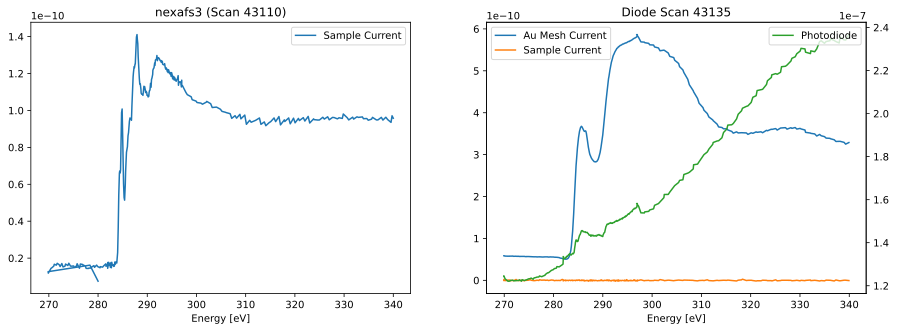

In [23]:
# Sample scan:
energy, mesh, sample, beamstop = read_interp(scan_number, samplePath, detector='SAXS')
pol, s_pol = get_pol(scan_number, samplePath)
sample_name = get_name(scan_number, samplePath)

# Diode scan:
diode_energy, diode_mesh, diode_sample, diode_beamstop = read_interp(diode_scan, diodePath, detector='SAXS')
diode_pol, diode_s_pol = get_pol(diode_scan, diodePath)

# Plotting:
def plot():
    print(f'Sample scan: sample polarization = {s_pol}, actual polarization = {pol}')
    print(f'Diode scan: sample polarization = {diode_s_pol}, actual polarization = {diode_pol}')

    fig, (sample_ax, diode_ax) = plt.subplots(1,2)
    fig.set(size_inches=(15,5))

    sample_ax.set(title=f'{sample_name} (Scan {scan_number})', xlabel='Energy [eV]')
    sample_ax.plot(energy, sample, label='Sample Current')
    sample_ax.legend()

    diode_ax.set(title=f'Diode Scan {diode_scan}', xlabel='Energy [eV]')
    diode_ax.plot(diode_energy, diode_mesh, label='Au Mesh Current')
    diode_ax.plot(diode_energy, diode_sample, label='Sample Current')
    diode_ax.legend(loc='upper left')
    diode_ax.set_xlabel('Energy [eV]')
    ax2 = diode_ax.twinx()
    ax2.plot(diode_energy, diode_beamstop, color='tab:green',label='Photodiode')
    ax2.legend(loc='upper right')
    plt.show()
    
plot()

### Slice to remove any bad points and interpolate to fewer points if very noisy

Sample scan: sample polarization = 90.0, actual polarization = 90.0
Diode scan: sample polarization = 90.0, actual polarization = 90.0


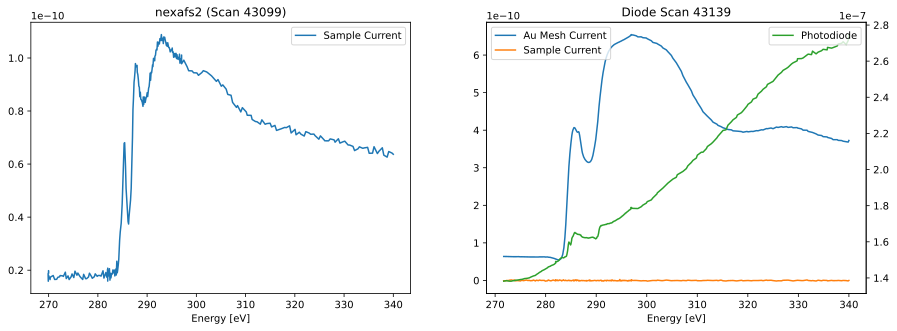

In [78]:
loaded_data = [energy, mesh, sample, beamstop, diode_energy, diode_mesh, diode_sample, diode_beamstop]
sliced_data = []
for loaded in loaded_data:
    loaded = loaded[10:]
    sliced_data.append(loaded)

energy, mesh, sample, beamstop, diode_energy, diode_mesh, diode_sample, diode_beamstop = sliced_data
plot()

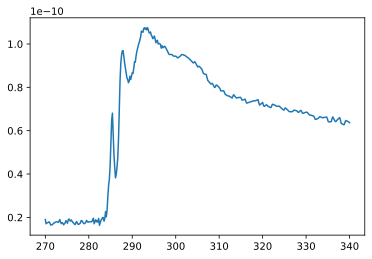

In [79]:
energy_less = np.linspace(270,340,400)
sample_less = np.interp(energy_less, energy, sample)
mesh_less = np.interp(energy_less, energy, mesh)

plt.plot(energy_less, sample_less)
plt.gcf().set(dpi=100)
plt.show()

In [80]:
energy = energy_less
sample = sample_less
mesh = mesh_less

# Offset sample mesh currrent to match photodiode mesh current

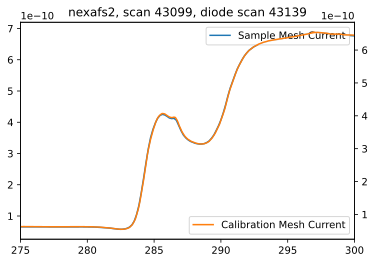

In [81]:
# Adjust sample_offset until the curves line up
sample_offset = 0

fig, ax = plt.subplots()
fig.set(dpi=100)
ax.set(title=f'{sample_name}, scan {scan_number}, diode scan {diode_scan}')
ax.plot(energy + sample_offset, mesh, label='Sample Mesh Current')
ax.legend(loc='upper right')
ax2 = ax.twinx()
ax2.plot(diode_energy, diode_mesh, color='tab:orange',label='Calibration Mesh Current')
ax2.legend(loc='lower right')
plt.xlabel('Energy [eV]')
plt.xlim(275, 300)
plt.show()

In [82]:
# Apply offset to calibrate sample to diode
energy += sample_offset

# Calculate and apply double normalization factor

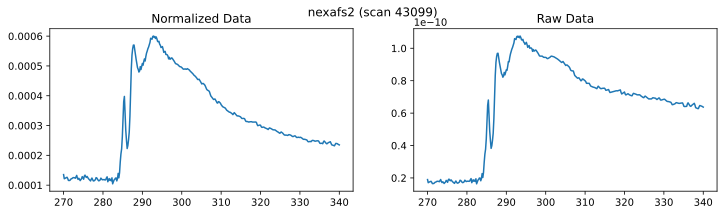

In [83]:
# Calculate double normalization factor from the diode scan
double_norm = diode_mesh/diode_beamstop
double_norm_interp = np.interp(energy, diode_energy, double_norm)

normed_data = (sample/mesh)*double_norm_interp
fig, (ax1, ax2) = plt.subplots(1,2)
fig.suptitle(f'{sample_name} (scan {scan_number})')
ax1.plot(energy, normed_data)
ax1.set_title('Normalized Data')
ax2.plot(energy, sample)
ax2.set_title('Raw Data')
fig.set(size_inches=(12,3), dpi=100)
plt.show()

Apply the double normalization and replot the NEXAFS

### KK Calc

kkcalc does the transform from the atomic scattering factor quantity. Once you have the real and imaginary components you can convert that into delta and beta using the density and formula mass.

The goal of the code that follows is to extract the complex index of refraction of one material using experimental NEXAFS of a blend of that material with another, using the optical constants of the second material and known volume fractions. The calculation relies on the Arago-Biot equation for the refractive index of material mixtures. Unknown if any of this is correct :)

In [84]:
# Input density, chemical formula (of monomer), and polymer molecular weight (a.m.u's)
density = 1.3
Y6_chem_form = {'C': 82, 'H': 86, 'O': 2, 'S': 5, 'F': 4, 'N': 8}
PM6_chem_form = {}
chem_form = Y6_chem_form
mw_monomer = calculateMW(chem_form)
mw_polymer = mw_monomer

dp = calculateDP(mw_polymer, mw_monomer)

polymer_chem_form = {}
for i in chem_form:
    polymer_chem_form[i] = chem_form[i]*dp
    
stoic_string = ''
dict_array = (np.array(list(polymer_chem_form.items())))
for item in dict_array.reshape(dict_array.size):
    stoic_string = stoic_string + item

In [85]:
# Parse chemical formula and calculate formula mass
stoichiometry = kk.data.ParseChemicalFormula(stoic_string)
formula_mass = data.calculate_FormulaMass(stoichiometry)

# Calculate Atomic Scattering Factors from Henke Database
ASF_E, ASF_Data = kk.data.calculate_asf(stoichiometry)
ASF_Data2 = kk.data.coeffs_to_ASF(ASF_E, np.vstack((ASF_Data, ASF_Data[-1])))
ASF_Data3 = kk.data.coeffs_to_ASF(ASF_E[:-1], ASF_Data)

# Rename energy and normed nexafs data
e = energy
nexafs = normed_data

# Merge Henke data with NEXAFS
merge_min = e.min()
merge_max = e.max()
merged = data.merge_spectra(np.column_stack((e, nexafs)), ASF_E, ASF_Data, merge_points=(merge_min,merge_max), add_background=False, fix_distortions=True, plotting_extras=True)

# Calculate relativistic correction
correction = kk.calc_relativistic_correction(stoichiometry)

# Calculate real component of ASF from merged data
real = kk.KK_PP(merged[2][:,0], merged[0], merged[1], correction)

# Conversion to delta and beta
delta = data.convert_data(np.column_stack((merged[2][:,0], real)),'ASF','refractive_index', Density=density, Formula_Mass=formula_mass)
beta = data.convert_data(merged[2],'ASF','refractive_index', Density=density, Formula_Mass=formula_mass)

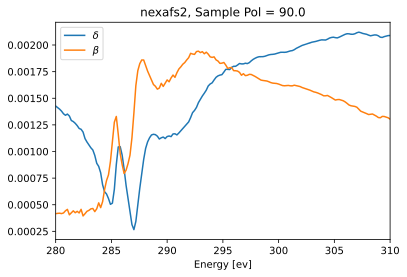

In [86]:
fig, ax = plt.subplots()
ax.plot(delta[:,0],delta[:,1],label=r'$\delta$')
ax.plot(beta[:,0],beta[:,1],label=r'$\beta$')
ax.set_title(f'{sample_name}, Sample Pol = {s_pol}')
ax.set_xlim(280, 310)
ax.legend()
ax.set_xlabel('Energy [ev]')
fig.set(dpi=120)
plt.show()

### Save data if it looks good:

In [87]:
# Write data to array with energy, delta, and beta as columns
energy_delta_beta = np.hstack((delta, beta[:,1].reshape(len(beta),1)))

# Save as txt file
np.savetxt(difxnPath.joinpath(f'{sample_name}_sPol_{s_pol}_energy-delta-beta.txt'), energy_delta_beta)

## Saving full arrays for materials with delta and beta, para and perp

### Load all saved arrays into dictionary

In [5]:
txt_files = list(difxnPath.glob('*eta.txt'))
data_dict = {}

for i, file in enumerate(txt_files):
    txt_string = file.name[:-24]  #Slice filename for how you'd like to call the numpy arrays
    vars().__setitem__(txt_string, np.loadtxt(txt_files[i]))
    data_dict[txt_string] = vars()[txt_string]

sorted(data_dict.keys())

['nexafs1_sPol_30',
 'nexafs1_sPol_40',
 'nexafs1_sPol_55',
 'nexafs1_sPol_70.',
 'nexafs1_sPol_89.',
 'nexafs1_sPol_90',
 'nexafs2_sPol_30',
 'nexafs2_sPol_90',
 'nexafs3_sPol_30',
 'nexafs3_sPol_90',
 'nexafs4_sPol_30']

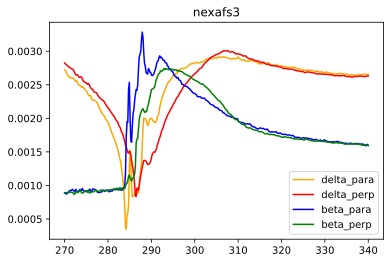

In [18]:
# Choose a material name from the list above
material_name = 'nexafs3'

# Defines para and perp as just 0 and 90 degree cuts, this isn't super rigorous and only semi-works for higly anisotropci samples
energies = data_dict[f'{material_name}_sPol_30'][:,0] 
delta_para = data_dict[f'{material_name}_sPol_30'][:,1]
delta_perp = np.interp(energies, data_dict[f'{material_name}_sPol_90'][:,0], data_dict[f'{material_name}_sPol_90'][:,1])
beta_para = data_dict[f'{material_name}_sPol_30'][:,2]
beta_perp = np.interp(energies, data_dict[f'{material_name}_sPol_90'][:,0], data_dict[f'{material_name}_sPol_90'][:,2])

# Plot/check it
plt.plot(energies, delta_para, label='delta_para', c='orange')
plt.plot(energies, delta_perp, label='delta_perp', c='red')
plt.plot(energies, beta_para, label='beta_para', c='blue')
plt.plot(energies, beta_perp, label='beta_perp', c='green')
plt.legend()
plt.title(f'{material_name}')
# plt.gcf().set(dpi=120)
plt.show()

In [130]:
# Define path where you want to save full para/perp txt files

savePath = notebookPath.joinpath('cyrsoxs_nexafs')
savePath.mkdir(exist_ok=True)
savePath.exists()  # Make sure you didn't typo anything

True

In [131]:
full_array = np.vstack((energies, delta_para, delta_perp, beta_para, beta_perp)).T
np.savetxt(savePath.joinpath(f'{material_name}_e-dpa-dpe-bpa-bpe.txt'), full_array)

## Contrast function stuff (not written yet)

In [ ]:
# # Contrast:
# def contrast(delta1, beta1, delta2=0, beta2=0):
#     energy = delta1[:,0]
#     delta1, beta1 = delta1[:,1], beta1[:,1]
#     if delta2 != 0 or beta2 != 0:
#         delta2, beta2 = delta2[:,1], beta2[:,1]
    
#     return (energy**4) * ((delta1-delta2)**2 + (beta1-beta2)**2)

In [ ]:
# c = contrast(delta,beta)
# plt.plot(delta[:,0], c)
# plt.yscale("log")
# plt.xlim(270,300)
# plt.title(f"{sample_name} vs Vacuum Contrast, pol = {pol}")

In [ ]:
# def get_contrast(file1, file2):
#     """
#     Function that accepts two files with columns energy, delta, beta and outputs the 
#     contrast function of the two materials
#     """